In [1]:
import os
from PIL import Image
import numpy as np
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from load_images import load_images
import image_utils

In [2]:
image_matrix, label_array, img_size = load_images('YaleB')
data_raw = image_matrix.reshape(-1,img_size[0],img_size[1])


In [3]:
split_point = int(0.8*len(data_raw))
data = data_raw.astype('float32') / 255.
x_train = data[:split_point]
x_test = data[split_point:]
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(type(x_train[0]))
print (x_train.shape)
print (x_test.shape)

<class 'numpy.ndarray'>
(1931, 192, 168, 1)
(483, 192, 168, 1)


In [4]:
class ConvAutoEncoder(Model):
  def __init__(self):
    super(ConvAutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(img_size[0], img_size[1], 1)),
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(4, (3,3), activation='relu', padding='same', strides=2),
      layers.Flatten(),
      layers.Dense(64, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(2016, activation="relu"),
      layers.Reshape((24,21,4)),
      layers.Conv2DTranspose(4, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = ConvAutoEncoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss=losses.MeanSquaredError())
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 84, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 42, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 21, 4)      │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       129,088 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,700 (510.55 KB)

 Trainable params: 130,700 (510.55 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=40,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 297ms/step - loss: 0.1070 - val_loss: 0.0766
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - loss: 0.0671 - val_loss: 0.0194
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - loss: 0.0302 - val_loss: 0.0137
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 429ms/step - loss: 0.0217 - val_loss: 0.0113
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 538ms/step - loss: 0.0185 - val_loss: 0.0098
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 394ms/step - loss: 0.0160 - val_loss: 0.0091
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - loss: 0.0144 - val_loss: 0.0083
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - loss: 0.0126 - val_loss: 0.0078
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 377ms/step - loss: 0.0115 - val_loss: 0.0075
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - loss: 0.0109 - val_loss: 0.0071


In [7]:
transformed_data = autoencoder.encoder(data).numpy()

In [8]:
explained_variance_absolute = np.var(transformed_data,axis=0,ddof=1)
explained_variance_ratio = explained_variance_absolute/sum(explained_variance_absolute)

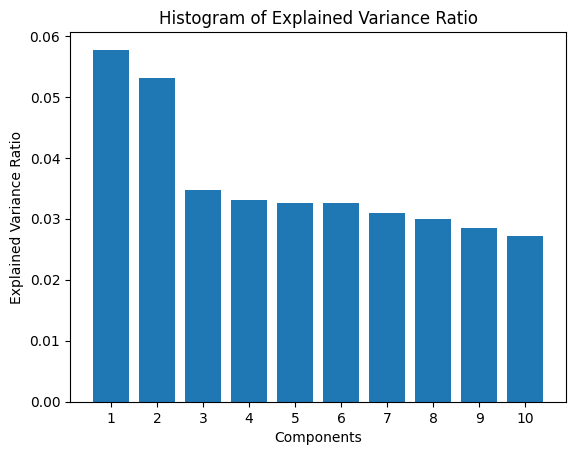

In [9]:
explained_variance_ratio = np.sort(explained_variance_ratio)
explained_variance_ratio = np.flip(explained_variance_ratio)
explained_variance = explained_variance_ratio[:10]
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Histogram of Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))  # Adding 1 to include all components in the axis
plt.show()

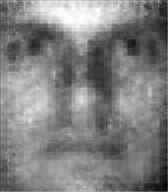

In [10]:
k = 200 # Image to be reconstructed

reconstructed_matrix = autoencoder.decoder(transformed_data[k:k+1]).numpy()

reconstructed_image = np.squeeze(reconstructed_matrix)

# Apply min-max normalization to scale pixel values to 0-255 for display
min_val = np.min(reconstructed_image)
max_val = np.max(reconstructed_image)
reconstructed_image_normalized = 255 * (reconstructed_image - min_val) / (max_val - min_val)
reconstructed_image_normalized = Image.fromarray(np.uint8(reconstructed_image_normalized))

# Display the reconstructed image directly in the notebook
display(reconstructed_image_normalized)



Accuracy: 0.33
Classification Report:
              precision    recall  f1-score   support

          01       0.58      0.44      0.50        16
          02       0.56      0.56      0.56        16
          03       0.64      0.44      0.52        16
          04       0.11      0.38      0.17        16
          05       0.57      0.75      0.65        16
          06       0.23      0.38      0.29        16
          07       0.19      0.38      0.26        16
          08       0.80      0.25      0.38        16
          09       0.64      0.44      0.52        16
          10       0.62      0.50      0.55        16
          11       0.25      0.07      0.11        15
          12       0.50      0.07      0.12        15
          13       1.00      0.27      0.42        15
          15       0.56      0.31      0.40        16
          16       0.83      0.31      0.45        16
          17       0.23      0.19      0.21        16
          18       0.25      0.06      0.10

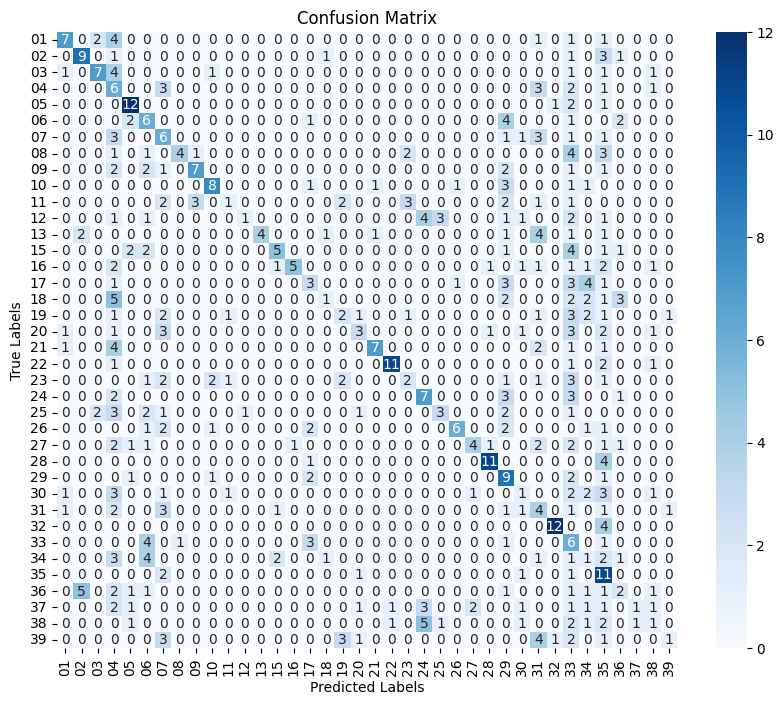

In [11]:
# Unique classes in the dataset
unique_classes = np.unique(label_array)

# Initialize lists to hold the split results
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

train_indices = []
test_indices = []

for cls in unique_classes:
    indices = np.where(label_array == cls)[0]
    train_idx, test_idx = train_test_split(indices, train_size=0.75, random_state=42, shuffle=True)
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

# Use the indices to split both the original and transformed datasets
X_train = transformed_data[train_indices]
X_test = transformed_data[test_indices]
y_train = label_array[train_indices]
y_test = label_array[test_indices]

svm = SVC(kernel='linear', random_state=42, C=0.001)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
    
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#
#print("Evaluation on Original Data with SVM:")
#evaluate_model(svm, X_train_pca, y_train, X_test_pca, y_test)